In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_spd_matrix


In [14]:
def generate_cosine_data(m=100, d=3, noise=0.01):
    """
    Generates data on the sphere in R^d with labels y = cos(<x, u>) + noise

    Returns:
        X: ata points on the sphere
        y: target values using cosine of dot product
        u: the true vector
    """
    X = np.random.randn(m, d)
    X /= np.linalg.norm(X, axis=1, keepdims=True)  

    u = np.random.randn(d)
    u /= np.linalg.norm(u)

    y = np.cos(X @ u) + np.random.normal(0, noise, size=m)
    
    return X, y, u

In [15]:
def generate_training_data_unfixed(m=100, n=2, noise=0.01):
    """
    Generates synthetic training data:
    - x_i ~ N(2,1)
    - y_i = Ax_i + b + noise
    """
    
    X = np.random.normal(loc=2, scale=1, size=(m, n))
    A = np.random.normal(0, 1, size=(n,)) 
    b = np.random.normal(0, 1)
    eta_i = np.random.normal(0, noise, size=(m,))
    y = X @ A + b + eta_i
    true_coefficients = {'A': A, 'b': b}
    return X, y, true_coefficients

In [16]:
def generate_training_data_fixed(m=100, n=2, noise=0.01, model_type='linear', nonlinear_func=None):
    """
    Generates synthetic training data with fixed A and b coefficients for linear regression, polynomial regression, and nonlinear cases.
    """
    X = np.random.normal(loc=2, scale=1, size=(m, n))
    if model_type == 'linear':
        A = np.array([1.0, 2.0])[:n]  
        b = 1.0                       
        eta_i = np.random.normal(0, noise, size=(m,))
        y = X @ A + b + eta_i
        true_coefficients = {'A': A, 'b': b}
        print(true_coefficients)
        
    elif model_type == 'polynomial':
        A_poly = np.array([1.0, 0.5, 0.3, 0.2])
        b = 1.0
        eta_i = np.random.normal(0, noise, size=(m,))
        X_poly = np.hstack([X, X**2])  
        y = X_poly @ A_poly + b + eta_i
        true_coefficients = {'A': A_poly, 'b': b}
        X = X_poly
    
    elif model_type == 'nonlinear':
        b = 1.0
        eta_i = np.random.normal(0, noise, size=(m,))
        y = nonlinear_func(X[:, 0]) + b + eta_i
        true_coefficients = {'function': nonlinear_func.__name__, 'b': b}
    
    return X, y, true_coefficients
    

In [17]:
# need model to fit true data, variable issue, have model have fit true data
# y_i = Ax_i + b + noise
# linear
# polynomial
# tradeoff: higher-deg is richer, but more parameters therefore need more data

# LOOK TO SEE IF ISSUE WITH BIAS TERM FOR POLYNOMIAL CASES
# y = f(x) (sphere in R^d) + ita
# estimates with polynomial regression approximation
# (x_i, y_i) dim iid from sphere
# If n is greater than the dimension of polynomial sphere
# gradient steps and model steps have a different rule
#y = cos(x) . u + ita
class SGD:
    """""
    Stochastic Gradient Descent for Linear and Polynomial Regression

    Supports arbitrary data sampling strategies. Handles regression on data generated
    from a linear or polynomial model. User specifies the polynomial degree; degree=1
    corresponds to linear regression. 
    
        Model (Linear Case):
            - Prediction: ŷ_i = w_0 + w_1 x_i1 + ... + w_n x_in
            - Loss: f_i(w) = (1/2) (w^T x_{i,new} - y_i)^2
            - Objective: F(w) = (1/m) Σ f_i(w)
            - Gradient: ∇f_i(w) = (w^T x_{i,new} - y_i) x_{i,new}
        
        Model (Polynomial Case):
            - Prediction: ŷ_i = w_0 + w_1 x_i1 + w_2 x_i1^2
    """""
    def __init__(self, X, y, num_iterations=1000, noise=0.001, degree=1):
        """
        Initializes the SGD model with generated data. 

        Args:
            X: The input data matrix of shape (m, n), where m is the number of samples 
                and n is the number of features.
            y: The output data vector of shape (m,).
            num_iterations: The number of iterations for running the SGD optimization. Defaults to 1000.
            noise: The standard deviation of the noise added to the output. Defaults to 0.001.
            degree: The degree of the polynomial features. Defaults to 1 (linear regression).
        """
        self.X = X
        self.y = y.flatten()
        self.m, self.n = X.shape
        self.degree = degree
        self.noise = noise
        self.num_iterations = num_iterations

        self.X_model = self.generate_polynomial_features(self.X, degree)
        self.n_model = self.X_model.shape[1]
        
        self.w = np.zeros(self.n_model)
        self.w_star = np.linalg.solve(self.X_model.T @ self.X_model, self.X_model.T @ self.y)
        self.F_star = self.F(self.w_star)

        self.L = self.compute_L()
        self.c = self.compute_c()
        self.mu, self.mu_G, self.M, self.M_V, self.M_G = self.estimate_parameters()
        self.fixed_alpha = self.compute_fixed_stepsize()
    
    def generate_polynomial_features(self, X, degree):
        """
        Generates polynomial features up to the specified degree.
        
        Args:
            X: The input data matrix.
            degree: The degree of the polynomial features.

        Returns:
            X_poly: The polynomial feature matrix.
        """
        X_poly = [np.ones((X.shape[0], 1))] 
        for d in range(1, degree + 1):
            X_poly.append(X ** d)
        return np.hstack(X_poly)
        
    def f_i(self, w, i):
        """
        Computes the loss for a single sample.

        Args:
            w: The parameter vector.
            i: The index of the current training sample.

        Returns:
            he loss for the i-th training sample.
        """
        return 0.5 * (self.X_model[i] @ w - self.y[i]) ** 2
    
    def grad_f_i(self, w, i):
        """
        Computes the gradient of the loss function with respect to parameters for a single sample.

        Args:
            w: The parameter vector.
            i: The index of the current training sample.

        Returns:
            The gradient of the loss function for the i-th sample.
        """
        return (self.X_model[i] @ w - self.y[i]) * self.X_model[i]
    

    def F(self, w):
        """
        Computes the average loss over all samples.

        Args:
            w: The parameter vector.

        Returns:
            float: The average loss over all samples.
        """
        F = (1/self.m) * sum(self.f_i(w, j) for j in range(self.m))
        return F

    def grad_F(self, w):
        """
        Computes the gradient of the objective function with respect to the parameters.

        Args:
            w: The parameter vector.

        Returns:
            The gradient of the objective function.
        """
        grad_F = (1/self.m) * sum(self.grad_f_i(w, i) for i in range(self.m))
        return grad_F
    
    def stochastic_grad(self):
        """
        Computes the stochastic gradient (using a random training sample).

        Returns:
            The stochastic gradient based on a randomly selected training sample.
        """
        i = np.random.randint(0, self.m)
        grad = self.grad_f_i(self.w, i)
        return grad 
    
    def mini_batch_grad(self):
        """
        Computes the mini-batch gradient (using a random subset of training samples).

        Args:
            batch_size: The number of samples in the mini-batch.

        Returns:
            The mini-batch gradient.
        """
        indices = np.random.choice(self.m, self.batch_size, replace=False)
        return (1 / self.batch_size) * sum(self.grad_f_i(self.w, i) for i in indices)
    
    def compute_L(self, num_samples=1000):
        """
        Computes the Lipschitz constant L of the gradient of the objective function.

        Args:
            num_samples: The number of random samples to estimate L. Default is 1000.

        Returns:
            The estimated Lipschitz constant.
        """
        L_vals = []
        d = self.X_model.shape[1]
        for _ in range(num_samples):
            w1, w2 = np.random.randn(d), np.random.randn(d)
            grad_diff = np.linalg.norm(self.grad_F(w1) - self.grad_F(w2), 2)
            w_diff = np.linalg.norm(w1 - w2, 2)
            
            if w_diff > 1e-8: 
                L_vals.append(grad_diff / w_diff)
        return max(L_vals) if L_vals else 1.0
    
    def compute_c(self):
        """
        Computes the constant c associated with strong convexity (Assumption 4.5).

        Args:
            num_samples (int): The number of random samples to estimate L. Default is 1000.

        Returns:
            float: The constant c.
        """
        H = (1/self.m) * (self.X_model.T @ self.X_model)
        eigenvalues = np.linalg.eigvalsh(H)
        c = max(min(eigenvalues), 1e-6) 
        return c
    
    def estimate_parameters(self, num_samples=200):
        """
        Estimates the parameters bounding the variance of the gradient updates.

        Returns:
            tuple: Estimated parameters (mu, mu_G, M, M_V, M_G).
        """
        mu = 1 
        mu_G = 1
        sigma2 = self.noise ** 2
        x_norms_squared = np.sum(self.X_model ** 2, axis=1)
        E_x_norm_sq = np.mean(x_norms_squared)
        x_norms_fourth = x_norms_squared ** 2 
        E_x_norm_fourth = np.mean(x_norms_fourth)
        M = sigma2 * E_x_norm_sq
        w_diff = self.w - self.w_star
        E_w_minus_A_sq = np.mean(w_diff ** 2)
        M_V = E_w_minus_A_sq * E_x_norm_fourth
        M_G = M_V + mu_G ** 2
        return mu, mu_G, M, M_V, M_G
        
    def compute_fixed_stepsize(self):
        """
        Computes the fixed stepsize for SGD using estimated parameters.

        Returns:
            float: The computed fixed stepsize for the SGD algorithm.
        """
        fixed_alpha = (self.mu / (self.L * self.M_G))
        print(f"Parameters: L = {self.L}, c = {self.c}, M_V = {self.M_V}, mu = {self.mu}, mu_G = {self.mu_G}, M_G = {self.M_G}, M = {self.M} \n Fixed Stepsize: alpha_bar = {fixed_alpha}")
        return fixed_alpha
    
    def compute_halving_stepsize(self):
        """
        Halves stepsize for SGD using estimated parameters.
        
        Returns:
            float: The necessary parameters for computing the havling stepsize in optimize method.

        """
        alpha = self.fixed_alpha
        F_alpha = (alpha * self.L * self.M) / (2 * self.c * self.mu)
        min_alpha = 1e-5
        return alpha, F_alpha, min_alpha
    # figure out when to halve (dynamically look at when gradient stops changing enough)
    
    def compute_diminishing_stepsize(self):
        gamma = ((self.L * self.M_G) / (self.c * self.mu))
        beta = (1 / (self.c * self.mu)) + (self.mu / (self.L * self.M_G))
        print(f"Diminishing Stepsize Parameters: beta = {beta:.4f}, gamma = {gamma:.4f}")
        return beta, gamma
    
    def optimize(self, stepsize_type='fixed', batch_size=1):
        """
        Runs the SGD optimization process for a specified number of iterations.

        Args:
            stepsize_type: 'fixed', 'halving', or 'diminishing' stepsize.

        Returns:
            tuple: Optimized parameters, the history of the objective function, gradient norms, and 
                   distance to the optimal solution.
        """
        self.batch_size = batch_size
        self.w = np.zeros(self.n_model)
        w = self.w
        if stepsize_type == 'fixed':
            alpha = self.fixed_alpha
            beta, gamma, halving_alpha, F_alpha, min_alpha = None, None, None, None, None
        elif stepsize_type == 'diminishing':
            beta, gamma = self.compute_diminishing_stepsize()
            alpha, halving_alpha, F_alpha, min_alpha = None, None, None, None
        else:  
            halving_alpha, F_alpha, min_alpha = self.compute_halving_stepsize()
            alpha, beta, gamma = None, None, None
        obj_history = [self.F(w)]
        grad_norm_history = [np.linalg.norm(self.grad_F(w))**2]
        dist_to_opt_history = [np.linalg.norm(w - self.w_star)**2]
        
        current_alpha = halving_alpha if stepsize_type == 'halving' else None
        current_F_alpha = F_alpha if stepsize_type == 'halving' else None
        r = 1  
        k_r = 1  
        halving_points = [k_r]
    
        for k in range(self.num_iterations):
            if stepsize_type == 'fixed':
                alpha_k = self.fixed_alpha
            elif stepsize_type == 'diminishing':
                alpha_k = beta / (gamma + k)
            else:  
                obj_value = self.F(w)
                gap = obj_value - self.F_star
                if gap < 2 * current_F_alpha:
                    r+=1
                    k_r = k + 1
                    halving_points.append(k_r)
                    current_alpha = max(current_alpha / 2, min_alpha)
                    current_F_alpha = (current_alpha * self.L * self.M) / (2 * self.mu)  
                    print(f"halving stepsize to {current_alpha:.10f}")
                alpha_k = current_alpha
            self.w = w
            if self.batch_size > 1:
                g_k = self.mini_batch_grad()
            else:
                g_k = self.stochastic_grad()
            w -= alpha_k * g_k
            obj_history.append(self.F(w))
            grad_norm_history.append(np.linalg.norm(self.grad_F(w))**2)
            dist_to_opt_history.append(np.linalg.norm(w - self.w_star)**2)
        return w, np.array(obj_history), np.array(grad_norm_history), np.array(dist_to_opt_history)
    

In [ ]:
X, y, true_params = generate_training_data_unfixed(m=100, n=2, noise=0.1)
sgd = SGD(X, y, num_iterations=5000)


w_fixed, obj_fixed, grad_fixed, dist_fixed = sgd.optimize(stepsize_type='fixed')
w_halving, obj_halving, grad_halving, dist_halving = sgd.optimize(stepsize_type='halving')
w_diminishing, obj_diminishing, grad_diminishing, dist_diminishing = sgd.optimize(stepsize_type='diminishing')

print("True parameters:")
print(f"A: {true_params['A']}, b: {true_params['b']}")
print(f"Learned parameters (fixed step size): w_0 (bias) = {w_fixed[0]:.4f}, w_1 = {w_fixed[1]:.4f}, w_2 = {w_fixed[2]:.4f}")
print(f"Final Loss: {obj_fixed[-1]:.4f}")
print(f"Learned parameters (halving step size): w_0 (bias) = {w_halving[0]:.4f}, w_1 = {w_halving[1]:.4f}, w_2 = {w_halving[2]:.4f}")
print(f"Final Loss: {obj_halving[-1]:.4f}")
print(f"Learned parameters (diminishing step size): w_0 (bias) = {w_diminishing[0]:.4f}, w_1 = {w_diminishing[1]:.4f}, w_2 = {w_diminishing[2]:.4f}")
print(f"Final Loss: {obj_diminishing[-1]:.4f}")1
# plot (4.21) multiply k, should converge to a constant or stabilize

Parameters: L = 10.27042819761962, c = 0.10019316935719606, M_V = 94.29674303363251, mu = 1, mu_G = 1, M_G = 95.29674303363251, M = 1.1718974195043527e-05 
 Fixed Stepsize: alpha_bar = 0.0010217235209578552
Diminishing Stepsize Parameters: beta = 9.9817, gamma = 9768.5138
True parameters:
A: [ 0.69547004 -0.88234579], b: 0.6221504652832512
Learned parameters (fixed step size): w_0 (bias) = 0.2844, w_1 = 0.7915, w_2 = -0.8271
Final Loss: 0.0105
Learned parameters (halving step size): w_0 (bias) = 0.2836, w_1 = 0.7940, w_2 = -0.8210
Final Loss: 0.0106
Learned parameters (diminishing step size): w_0 (bias) = 0.2482, w_1 = 0.8021, w_2 = -0.8115
Final Loss: 0.0119


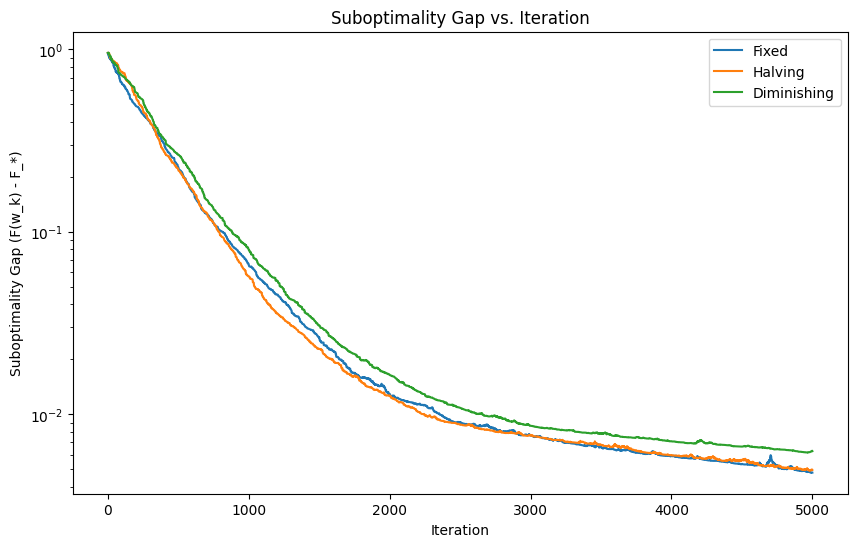

In [19]:
# Plotting the suboptimality gap

plt.figure(figsize=(10, 6))
plt.plot(obj_fixed - sgd.F_star, label='Fixed')
plt.plot(obj_halving - sgd.F_star, label='Halving')
plt.plot(obj_diminishing - sgd.F_star, label='Diminishing')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Suboptimality Gap (F(w_k) - F_*)')
plt.legend()
plt.title('Suboptimality Gap vs. Iteration')
plt.show()

In [20]:

X, y, u_true = generate_cosine_data(m=100, d=3, noise=0.01)
degrees = [1,2,3,4,5]
for degree in degrees:
    sgd = SGD(X, y, num_iterations=5000, degree=degree, noise=0.01)
    w_fixed, obj_fixed, grad_fixed, dist_fixed = sgd.optimize(stepsize_type='fixed')
    w_halving, obj_halving, grad_halving, dist_halving = sgd.optimize(stepsize_type='halving')
    w_diminishing, obj_diminishing, grad_diminishing, dist_diminishing = sgd.optimize(stepsize_type='diminishing')
    
    print(f"True parameters: {true_params}")
    print(f"\nLearned parameters with degree-{degree} polynomial features:\n")
    print(f"[Fixed]      w_0 (bias) = {w_fixed[0]:.4f}, rest = {w_fixed[1:]}")
    print(f"Final Loss: {obj_fixed[-1]:.4f}")
    print(f"[Halving]    w_0 (bias) = {w_halving[0]:.4f}, rest = {w_halving[1:]}")
    print(f"Final Loss: {obj_halving[-1]:.4f}")
    print(f"[Diminishing]w_0 (bias) = {w_diminishing[0]:.4f}, rest = {w_diminishing[1:]}")
    print(f"Final Loss: {obj_diminishing[-1]:.4f}")
    print("\n" + "="*50 + "\n")

Parameters: L = 1.0037703096995272, c = 0.2635476320971566, M_V = 0.7014811342657025, mu = 1, mu_G = 1, M_G = 1.7014811342657024, M = 0.0002 
 Fixed Stepsize: alpha_bar = 0.585515661665635
halving stepsize to 0.2927578308
Diminishing Stepsize Parameters: beta = 4.3799, gamma = 6.4804
True parameters: {'A': array([ 0.69547004, -0.88234579]), 'b': 0.6221504652832512}

Learned parameters with degree-1 polynomial features:

[Fixed]      w_0 (bias) = 0.9173, rest = [-0.00058809  0.04514147 -0.03144861]
Final Loss: 0.0151
[Halving]    w_0 (bias) = 0.8695, rest = [-0.03436274 -0.10805271  0.00028802]
Final Loss: 0.0127
[Diminishing]w_0 (bias) = 0.8336, rest = [-0.00028926  0.00168027  0.02004904]
Final Loss: 0.0104


Parameters: L = 1.237462168634309, c = 1e-06, M_V = 36.15156474043154, mu = 1, mu_G = 1, M_G = 37.15156474043154, M = 0.0002605311644111627 
 Fixed Stepsize: alpha_bar = 0.021751587534987755
halving stepsize to 0.0108757938
Diminishing Stepsize Parameters: beta = 1000000.0218, ga

In [21]:
X, y, true_params = generate_training_data_fixed(m=100, n=2, noise=0.01, model_type='nonlinear', nonlinear_func=np.cos)
degrees = [1,2,3,4,5]
for degree in degrees:
    sgd = SGD(X, y, num_iterations=5000, degree=degree, noise=0.01)
    w_fixed, obj_fixed, grad_fixed, dist_fixed = sgd.optimize(stepsize_type='fixed')
    w_halving, obj_halving, grad_halving, dist_halving = sgd.optimize(stepsize_type='halving')
    w_diminishing, obj_diminishing, grad_diminishing, dist_diminishing = sgd.optimize(stepsize_type='diminishing')
    
    print(f"True parameters: {true_params}")
    print(f"\nLearned parameters with degree-{degree} polynomial features:\n")
    print(f"[Fixed]      w_0 (bias) = {w_fixed[0]:.4f}, rest = {w_fixed[1:]}")
    print(f"Final Loss: {obj_fixed[-1]:.4f}")
    print(f"[Halving]    w_0 (bias) = {w_halving[0]:.4f}, rest = {w_halving[1:]}")
    print(f"Final Loss: {obj_halving[-1]:.4f}")
    print(f"[Diminishing]w_0 (bias) = {w_diminishing[0]:.4f}, rest = {w_diminishing[1:]}")
    print(f"Final Loss: {obj_diminishing[-1]:.4f}")
    print("\n" + "="*50 + "\n")

Parameters: L = 10.239981969844257, c = 0.09454673582150036, M_V = 165.55233915086524, mu = 1, mu_G = 1, M_G = 166.55233915086524, M = 0.0011448676468045313 
 Fixed Stepsize: alpha_bar = 0.0005863407409775785
Diminishing Stepsize Parameters: beta = 10.5774, gamma = 18038.6233
True parameters: {'function': 'cos', 'b': 1.0}

Learned parameters with degree-1 polynomial features:

[Fixed]      w_0 (bias) = 0.4193, rest = [-0.18390846  0.2786048 ]
Final Loss: 0.1377
[Halving]    w_0 (bias) = 0.4273, rest = [-0.17723122  0.30603868]
Final Loss: 0.1390
[Diminishing]w_0 (bias) = 0.4029, rest = [-0.16010371  0.28747685]
Final Loss: 0.1408


Parameters: L = 84.70945597510995, c = 0.02559767342551978, M_V = 58286.191464512514, mu = 1, mu_G = 1, M_G = 58287.191464512514, M = 0.011308403593163992 
 Fixed Stepsize: alpha_bar = 2.0253261857627566e-07
Diminishing Stepsize Parameters: beta = 39.0661, gamma = 192887697.1433
True parameters: {'function': 'cos', 'b': 1.0}

Learned parameters with degree-2

In [22]:
# def run_experiments_with_fixed_parameters():
#     #stepsizes = [0.001, 0.01, 0.1]
#     num_steps = [100, 1000, 5000]
#     noise_levels = [0.01, 0.1, 1.0]
    
    
#     for j, n_steps in enumerate(num_steps):
#         for k, noise in enumerate(noise_levels):
#             X, y, true_params = generate_training_data_fixed(100, 2, noise, 'linear')
#             sgd = SGD(X, y, num_iterations=n_steps)
#             w, obj, grad, dist = sgd.optimize()
#             label = f"Steps={n_steps}, Noise={noise}"
#             print("Linear function:")
#             print(f"{label}, Final Loss: {obj[-1]:.4f}")
            
#     for j, n_steps in enumerate(num_steps):
#         for k, noise in enumerate(noise_levels):
#             X_poly, y_poly, true_params_poly = generate_training_data_fixed(100, 2, noise, 'polynomial')
#             sgd_poly = SGD(X_poly, y_poly, num_iterations=n_steps)
#             w_poly, obj_poly, grad_poly, dist_poly = sgd_poly.optimize()
#             label = f"Steps={n_steps}, Noise={noise}"
#             print("Polynomial function:")
#             print(f"{label}, Final Loss: {obj_poly[-1]:.4f}")
    
#     for j, n_steps in enumerate(num_steps):
#         for k, noise in enumerate(noise_levels):
#             X_nonlin, y_nonlin, true_params_nonlin = generate_training_data_fixed(
#             100, 1, noise, 'nonlinear', nonlinear_func=np.cos
#         )
#             sgd_nonlin = SGD(X_nonlin, y_nonlin, num_iterations=n_steps)
#             w_nonlin, obj_nonlin, grad_nonlin, dist_nonlin = sgd_nonlin.optimize()
#             label = f"Steps={n_steps}, Noise={noise}"
#             print("Nonlinear function")
#             print(f"{label}, Final Loss: {obj_nonlin[-1]:.4f}")


In [23]:
# run_experiments_with_fixed_parameters()

In [24]:
#plt.figure(figsize=(15, 9))
#plt.subplot(3, 1, 1)
#plt.plot(obj_fixed - sgd.F_star, label='Fixed Stepsize')
#plt.ylabel('$F(w) - F(w_*)$')
#plt.title('Objective Function Decrease')
#plt.legend()
#plt.yscale('log')

#plt.subplot(3, 1, 2)
#plt.plot(grad_fixed, label='Fixed Stepsize')
#plt.ylabel('$||F(w)||^2$')
#plt.title('Gradient Norm Squared')
#plt.legend()
#plt.yscale('log')

#plt.subplot(3, 1, 3)
#plt.plot(dist_fixed, label='Fixed Stepsize')
#plt.xlabel('Iteration')
#plt.ylabel('$||w_k - w_*||^2$')
#plt.title('Distance to Optimum')
#plt.legend()
#plt.yscale('log')

#plt.tight_layout()
#plt.show()